# QF 627 Programming and Computational Finance
## `Py`Day Week `6` | Part `1`

### A Quick Scraper for FRED

In [1]:
!pip install beautifulsoup4

In [2]:
import requests

from bs4 import BeautifulSoup

In [3]:
import requests
from bs4 import BeautifulSoup

def obtain_fred_metadata(series_id):
    url = f"https://fred.stlouisfed.org/series/{series_id}"
    
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, "html.parser")

    # Extracting the description
    description_tag = soup.find("meta", {"name": "description"}
                               )
    if description_tag:
        return description_tag["content"]
    return None

In [4]:
#notes-content > p.series-notes.mb-2

In [5]:
obtain_fred_metadata("DEXJPUS")

'Graph and download economic data for Japanese Yen to U.S. Dollar Spot Exchange Rate (DEXJPUS) from 1971-01-04 to 2023-09-22 about Japan, exchange rate, currency, rate, and USA.'

### Causal Inference and Econometric Methods: `Synthetic Control`

In [6]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

import statsmodels.formula.api as smf

from matplotlib import style

style.use("ggplot")

import matplotlib as mpl

mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["axes.facecolor"] = "white"

### IMPORT

In [7]:
smoking =\
(
    pd
    .read_csv("tobacco.csv")
)

In [8]:
smoking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   retprice         1209 non-null   float64
 4   california       1209 non-null   bool   
 5   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 40.3 KB


In [9]:
smoking \
    .isnull() \
    .sum()

state              0
year               0
cigsale            0
retprice           0
california         0
after_treatment    0
dtype: int64

In [10]:
smoking.head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False


In [11]:
smoking.tail()

,state,year,cigsale,retprice,california,after_treatment
1204,39,1996,110.300003,162.500000,False,True
1205,39,1997,108.800003,164.100006,False,True
1206,39,1998,102.900002,168.800003,False,True
1207,39,1999,104.800003,189.600006,False,True
1208,39,2000,90.500000,267.100006,False,True


### WRANGLE

In [12]:
smoking \
    .query("california") \
    .head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


### EDA

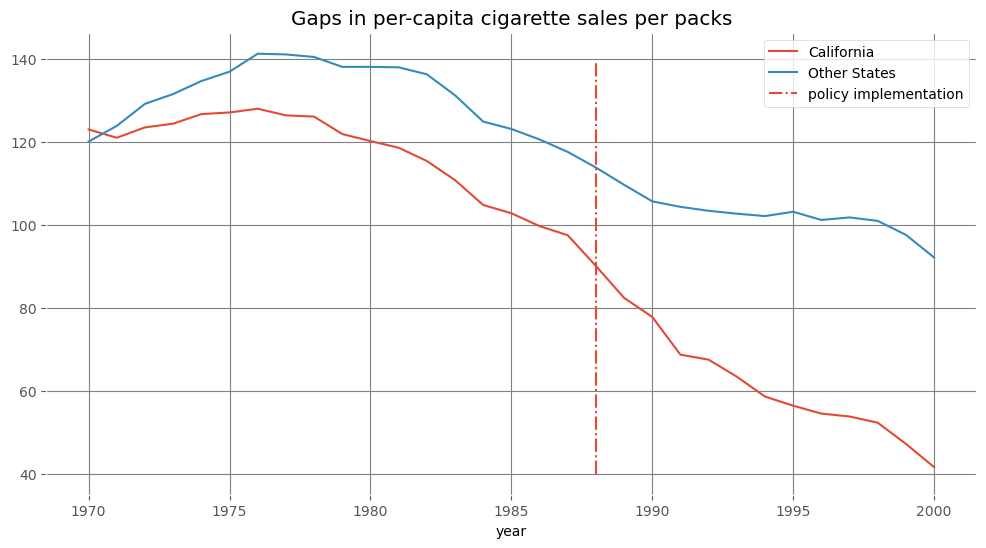

In [13]:
ax =\
    plt \
    .subplot(1, 1, 1)

(
    smoking
    .assign(california = np
                         .where(smoking["california"],
                                "California", "Other States")
           )
    .groupby(["year", "california"]
            )
    ["cigsale"] # variable of interest
    .mean() 
    .reset_index() 
    .pivot(index = "year",
           columns = "california",
           values = "cigsale")
    .plot(ax = ax,
          figsize = [12, 6]
         )
)

plt \
    .vlines(x = 1988,
            ymin = 40,
            ymax = 140,
            linestyle = "-.",
            label = "policy implementation")

plt \
    .title("Gaps in per-capita cigarette sales per packs")

plt.legend();

### Building a Counterfactual: A Synthetic Control

In [14]:
smoking.columns

Index(['state', 'year', 'cigsale', 'retprice', 'california',
       'after_treatment'],
      dtype='object')

In [15]:
key_variables = ["cigsale", "retprice"]

In [16]:
smoking.tail()

,state,year,cigsale,retprice,california,after_treatment
1204,39,1996,110.300003,162.500000,False,True
1205,39,1997,108.800003,164.100006,False,True
1206,39,1998,102.900002,168.800003,False,True
1207,39,1999,104.800003,189.600006,False,True
1208,39,2000,90.500000,267.100006,False,True


In [17]:
inverted_DF =\
(
    smoking
    .query("~after_treatment") # we want to obtain data before the event was implemented
    .pivot(index = "state",
           columns = "year")
    [key_variables] # operations
    .T
)

In [18]:
print(inverted_DF.head());print(inverted_DF.tail())

state                 1           2           3           4           5    
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000  \
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...   
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...  \
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  

In [19]:
inverted_DF.head()

state                 1           2           3           4           5    
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000  \
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...   
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...  \
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34   
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000  \
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
y =\
    inverted_DF[3] \
    .values

In [22]:
y

array([123.        , 121.        , 123.5       , 124.40000153,
       126.69999695, 127.09999847, 128.        , 126.40000153,
       126.09999847, 121.90000153, 120.19999695, 118.59999847,
       115.40000153, 110.80000305, 104.80000305, 102.80000305,
        99.69999695,  97.5       ,  90.09999847,  38.79999924,
        39.70000076,  39.90000153,  39.90000153,  41.90000153,
        45.        ,  48.29999924,  49.        ,  58.70000076,
        60.09999847,  62.09999847,  66.40000153,  72.80000305,
        84.90000153,  94.90000153,  98.        , 104.40000153,
       103.90000153, 117.40000153])

In [23]:
# x = other states (DF)

x =\
(
    inverted_DF
    .drop(columns = 3)
    .values
)

In [24]:
x

array([[ 89.80000305, 100.30000305, 124.80000305, ..., 114.5       ,
        106.40000153, 132.19999695],
       [ 95.40000153, 104.09999847, 125.5       , ..., 111.5       ,
        105.40000153, 131.69999695],
       [101.09999847, 103.90000153, 134.30000305, ..., 117.5       ,
        108.80000305, 140.        ],
       ...,
       [103.        , 103.59999847,  95.09999847, ..., 104.09999847,
        110.80000305,  97.80000305],
       [110.        , 113.        , 108.59999847, ..., 112.80000305,
        116.30000305, 102.69999695],
       [114.40000153, 119.90000153, 116.        , ..., 122.19999695,
        128.6000061 , 112.90000153]])

In [25]:
weights_of_ols =\
(
    LinearRegression(fit_intercept = False)
    .fit(x, y)
    .coef_
)

In [26]:
len(weights_of_ols) == 39 - 1

True

In [27]:
synthetic_california_ols =\
(
    smoking
    .query("~california")
    .pivot(index = "year",
           columns = "state")
    ["cigsale"]
    .values
    .dot(weights_of_ols)
)

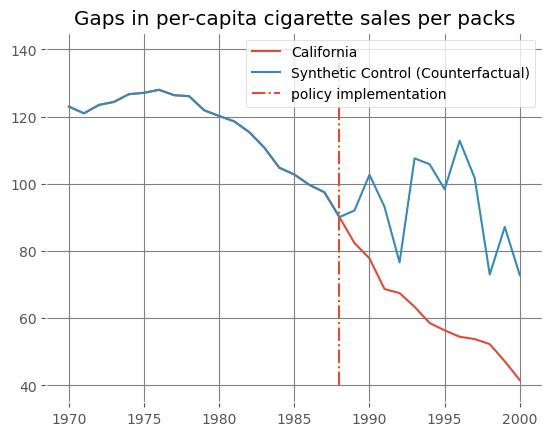

In [28]:
# Target with Event (Intervention)

(
    plt
    .plot(smoking.query("california")["year"],
          smoking.query("california")["cigsale"],
          label = "California")
)

# Counterfactual (Control): Synthetic California based on Other States

(
    plt
    .plot(smoking.query("california")["year"],
          synthetic_california_ols,
          label = "Synthetic Control (Counterfactual)")
)


plt \
    .vlines(x = 1988,
            ymin = 40,
            ymax = 140,
            linestyle = "-.",
            label = "policy implementation")

plt \
    .title("Gaps in per-capita cigarette sales per packs")

plt.legend();

In [29]:
from scipy.optimize import fmin_slsqp

In [30]:
from typing import List
from operator import add
from toolz import partial, reduce

In [31]:
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2)
                          )

In [32]:
def obtain_w(X, y):
    
    w_start = [1/X.shape[1]] * X.shape[1]
    
    weights =\
        fmin_slsqp(partial(loss_w, X = X, y = y),
                   np.array(w_start),
                   f_eqcons = lambda x: np.sum(x) - 1,
                   bounds = [(0.0, 1.0)] * len(w_start),
                   disp = False)
    return weights

In [33]:
realistic_california_weights = obtain_w(x, y)

In [34]:
# True (More realistic Counterfactual): What would have happened (without policy)

synthetic_california_with_realistic_weights =\
(
    smoking
    .query("~california")
    .pivot(index = "year",
           columns = "state")
    ["cigsale"]
    .values # ()
    .dot(realistic_california_weights)
)

In [35]:
synthetic_california_with_realistic_weights

array([116.37738088, 119.29341336, 125.46488162, 124.01126516,
       125.00610865, 126.12812193, 128.40416472, 126.33354829,
       125.65842478, 122.57699531, 121.02481027, 120.79008431,
       115.81667701, 112.72157966, 104.13403042, 103.31383473,
       101.67828382, 100.31140359,  92.6041438 ,  89.97954326,
        84.47435543,  80.4163098 ,  80.45152514,  79.60028843,
        79.11292836,  77.89062047,  77.22867226,  77.49826222,
        75.00565125,  73.8354918 ,  66.43015823])

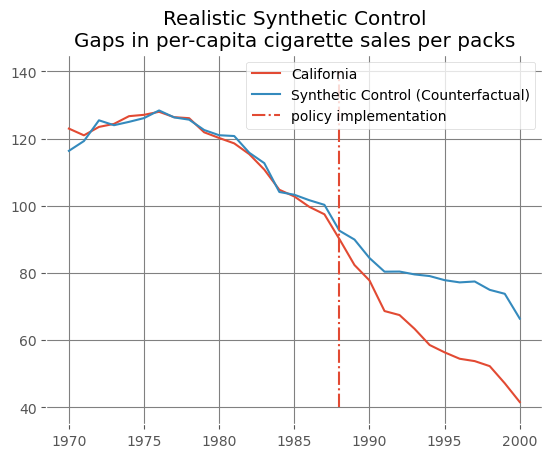

In [36]:
# Target with Event (Intervention)

(
    plt
    .plot(smoking.query("california")["year"],
          smoking.query("california")["cigsale"],
          label = "California")
)

# Counterfactual (Control): Synthetic California based on Other States

(
    plt
    .plot(smoking.query("california")["year"],
          synthetic_california_with_realistic_weights,
          label = "Synthetic Control (Counterfactual)")
)


plt \
    .vlines(x = 1988,
            ymin = 40,
            ymax = 140,
            linestyle = "-.",
            label = "policy implementation")

plt \
    .title("Realistic Synthetic Control\nGaps in per-capita cigarette sales per packs")

plt.legend();

### For Reporting, Please USE This :)

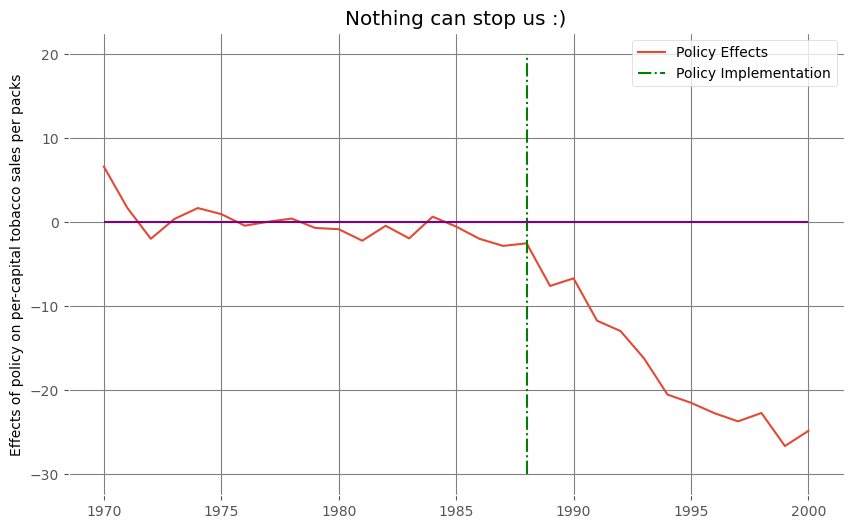

In [37]:
plt.figure(figsize = [10, 6]
          )

plt \
    .plot(smoking.query("california")["year"],
          smoking.query("california")["cigsale"] - synthetic_california_with_realistic_weights,
          label = "Policy Effects")

plt \
    .vlines(x = 1988,
            ymin = -30,
            ymax = 20,
            linestyle = "-.",
            label = "Policy Implementation",
            colors = "green")

plt \
    .hlines(y = 0,
            xmin = 1970,
            xmax = 2000,
            colors = "purple")

plt.ylabel("Effects of policy on per-capital tobacco sales per packs")

plt.title("Nothing can stop us :)")

plt.legend();

> Team, it was great seeing you tonight at `Py`Day! Wishing you a hap`PY` October &#128578;